# 🚀 Next: Adaptive Agent

Now you've learned the basics -- we can look at an application in building a reinforcement learning (RL) agent using Trace primitives.

## A Reinforcement Learning Agent

The essence of an RL agent is to react and adapt to different situations. An RL agent should change its behavior to become more successful at a task. Using `node`, `@bundle`, we can expose different parts of a Python program to an optimizer, making this program reactive to various feedback signals. A self-modifying, self-evolving system is the definition of an RL agent. By rewriting its own rules and logic, they can self-improve through the philosophy of *trial-and-error* (the Reinforcement Learning way!).

Building an RL agent (with program blocks) and use an optimize to react to feedback is at the heart of policy gradient algorithms (such as [PPO](https://arxiv.org/abs/1707.06347), which is used in RLHF -- Reinforcement Learning from Human Feedback). Trace changes the underlying program blocks to improve the agent's chance of success. Here, we can look at an example of how Trace can be used to design an RL-style agent to master the game of Battleship.

In [ ]:
%pip install trace-opt

In [2]:
import opto.trace as trace
from opto.trace import node, bundle, model, GRAPH
from opto.optimizers import OptoPrime

In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display

# Function to save the environment variable and API key
def save_env_variable(env_name, api_key):
    # Validate inputs
    if not env_name.strip():
        print("⚠️ Environment variable name cannot be empty.")
        return
    if not api_key.strip():
        print("⚠️ API key cannot be empty.")
        return
    
    # Store the API key as an environment variable
    os.environ[env_name] = api_key
    globals()[env_name] = api_key  # Set it as a global variable
    print(f"✅ API key has been set for environment variable: {env_name}")

# Create the input widgets
env_name_input = widgets.Text(
    value="OPENAI_API_KEY",  # Default value
    description="Env Name:",
    placeholder="Enter env variable name (e.g., MY_API_KEY)",
)

api_key_input = widgets.Password(
    description="API Key:",
    placeholder="Enter your API key",
)

# Create the button to submit the inputs
submit_button = widgets.Button(description="Set API Key")

# Display the widgets
display(env_name_input, api_key_input, submit_button)

# Callback function for the button click
def on_button_click(b):
    env_name = env_name_input.value
    api_key = api_key_input.value
    save_env_variable(env_name, api_key)

# Attach the callback to the button
submit_button.on_click(on_button_click)

Trace uses decorators like `@bundle` and data wrappers like `node` to expose different parts of these programs to an LLM. An LLM can rewrite the entire or only parts of system based on the user's specification. An LLM can change various parts of this system, with feedback they receive from the environment. Trace allows users to exert control over the LLM code-generation process.

## The Game of BattleShip

A simple example of how Trace allows the user to design an agent, and how the agent self-modifies its own behavior to adapt to the environment, we can take a look at the classic game of Battleship.

```{image} ../images/dall_e_battleship.jpeg
:alt: battleship
:class: bg-primary mb-1
:align: center
```

(Image credit: DALL-E by OpenAI)

We already implemented a simplified version of the battleship game. The game's rule is straightforward: our opponent has placed 8 ships on a square board. The ships vary in size, resembling a carrier, battleship, cruiser, submarine, and destroyer. We need to select a square to hit during each turn.

In [3]:
import sys
import os

# Get the absolute path of the examples folder
examples_path = os.path.abspath(os.path.join('..', '..', 'examples'))

# Add the examples folder to the Python path
sys.path.append(examples_path)

In [4]:
from battleship import BattleshipBoard

board = BattleshipBoard(8, 8)

# Show the ini+tial board with ships
board.render_html(show_ships=True)

,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


Of course, this wouldn't be much of a game if we are allowed to see all the ships laying out on the board -- then we would know exactly which square to place a shot! After we choose a square to place a shot, our opponent will reveal whether the shot is a hit or a miss!

In [5]:
# Make some shots
board.check_shot(0, 0)
board.check_shot(1, 1)
board.check_shot(2, 2)

# Show the board after shots
board.render_html(show_ships=False)

,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


## Define An Agent Using Trace

We can write a simple agent that can play this game. Note that we are creating a normal Python class and decorate it with `@model`, and then use `@bundle` to specify which part of this class can be changed by an LLM through feedback. 

```{tip}
Trace only has two main primitives: `node` and `@bundle`. Here, we introduce a "helper" decorator `@model` to expose more of the user-defined Python class to the Trace library, e.g., `@model` can be used for retrieving trainable parameters (declared by `node` and `@bundle`) in a Python class.
```

In [6]:
@model
class Agent:

    def __call__(self, map):
        return self.select_coordinate(map).data

    def act(self, map):
        plan = self.reason(map)
        output = self.select_coordinate(map, plan)
        return output

    @bundle(trainable=True)
    def select_coordinate(self, map, plan):
        """
        Given a map, select a target coordinate in a Battleship game.
        X denotes hits, O denotes misses, and . denotes unknown positions.
        """
        return None

    @bundle(trainable=True)
    def reason(self, map):
        """
        Given a map, analyze the board in a Battleship game.
        X denotes hits, O denotes misses, and . denotes unknown positions.
        """
        return None

Just like in the previous tutorial, we need to define a feedback function to provide the guidance to the agent to self-improve. We make it simple -- just telling the agent how much reward they obtained form the game environment.

In [7]:
# Function to get user feedback for placing shot
def user_fb_for_placing_shot(board, coords):
    try:
        reward = board.check_shot(coords[0], coords[1])
        new_map = board.get_shots()
        terminal = board.check_terminate()
        return new_map, int(reward), terminal, f"Got {int(reward)} reward."
    except Exception as e:
        return board.get_shots(), 0, False, str(e)

## Visualize Trace Graph of an Action

We can first take a look at what the Trace Graph looks like for this agent when it takes an observation `board.get_shots()` from the board (this shows the map without any ship but with past records of hits and misses). The agent takes an action based on this observation.

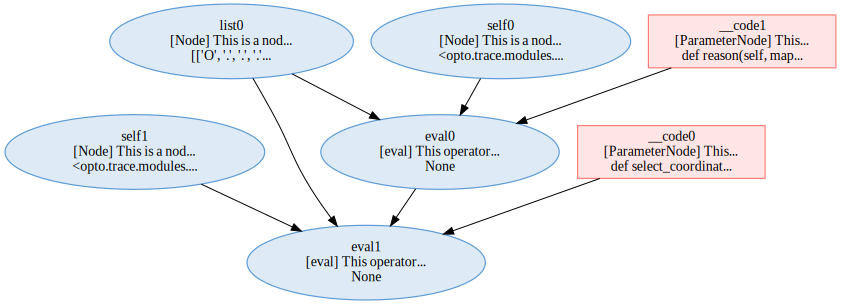

In [8]:
GRAPH.clear()

agent = Agent()
obs = node(board.get_shots(), trainable=False)
output = agent.act(obs)
output.backward(visualize=True, print_limit=20)

We can see that, this is the execution graph (Trace graph) that transforms the observation (marked as `list0`) to the output (marked as `select_coordinate0`). Trace opens up the blackbox of how an input is transformed to an output in a system. 

```{note}
Note that not all parts of the agent are present in this graph. For example, `__call__` is not in this. A user needs to decide what to include and what to exclude, and what's trainable and what's not. You can learn more about how to design an agent in the tutorials.
```

## Define the Optimization Process

Now let's see if we can get an agent that can play this game with environment reward information.

We set up the optimization procedure:
1. We initialize the game and obtain the initial state `board.get_shots()`. We wrap this in a Trace `node`.
2. We enter a game loop. The agent produces an action through `agent.act(obs)`.
3. The action `output` is then executed in the environment through `user_fb_for_placing_shot`.
4. Based on the feedback, the `optimizer` takes a step to update the agent

In [10]:
import autogen
from opto.trace.utils import render_opt_step
from battleship import BattleshipBoard

GRAPH.clear()

board = BattleshipBoard(8, 8)
board.render_html(show_ships=True)

agent = Agent()
obs = node(board.get_shots(), trainable=False)
optimizer = OptoPrime(agent.parameters(), config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

feedback, terminal, cum_reward = "", False, 0

iterations = 0
while not terminal and iterations < 10:
    try:
        output = agent.act(obs)
        obs, reward, terminal, feedback = user_fb_for_placing_shot(board, output.data)
        hint = f"The current code gets {reward}. We should try to get as many hits as possible."
        optimizer.objective = f"{optimizer.default_objective} Hint: {hint}"
    except trace.ExecutionError as e:
        output = e.exception_node
        feedback, terminal, reward = output.data, False, 0

    board.render_html(show_ships=False)

    cum_reward += reward

    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    optimizer.step(verbose=False)

    render_opt_step(iterations, optimizer, no_trace_graph=True)
    iterations += 1

,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


In [11]:
for p in agent.parameters():
    print(p.data)
    print()

def reason(self, map):
        """
        Given a map, analyze the board in a Battleship game.
        X denotes hits, O denotes misses, and . denotes unknown positions.
        """
        analysis = {'hits': 0, 'misses': 0, 'unknown': 0}
        for row in map:
            for cell in row:
                if cell == 'X':
                    analysis['hits'] += 1 # Normal count
                elif cell == 'O':
                    analysis['misses'] += 1
                elif cell == '.':
                    analysis['unknown'] += 1
        return analysis

def select_coordinate(self, map, plan):
        """
        Given a map, select a target coordinate in a Battleship game.
        X denotes hits, O denotes misses, and . denotes unknown positions.
        Uses a provided plan strategy to decide on the next move.
        """
        if plan['hits'] >= 1:
            for i, row in enumerate(map):
                for j, cell in enumerate(row):
                    if cell == '.' and su

## What Did the Agent Learn?

Then we can see how this agent performs in an evaluation run.

```{note}
A neural network based RL agent would take orders of magnitutde more iterations than 10 iterations to learn this kind of heuristics.
```

If you **scroll down** the output, you can see how the agent is playing the game step by step.
The agent learns to apply heuristics such as -- once a shot turns out to be a hit, they would hit the neighboring squares to **maximize** the chance of hitting a ship.

In [12]:
board = BattleshipBoard(8, 8)
board.render_html(show_ships=True)

terminal = False
for _ in range(15):
    try:
        output = agent.act(obs)
        obs, reward, terminal, feedback = user_fb_for_placing_shot(board, output.data)
    except trace.ExecutionError as e:
        # this is essentially a retry
        output = e.exception_node
        feedback = output.data
        terminal = False
        reward = 0

    board.render_html(show_ships=False)
    if terminal:
        break

,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,


,A,B,C,D,E,F,G,H,
1,,,,,,,,,
2,,,,,,,,,
3,,,,,,,,,
4,,,,,,,,,
5,,,,,,,,,
6,,,,,,,,,
7,,,,,,,,,
8,,,,,,,,,
,,,,,,,,,
